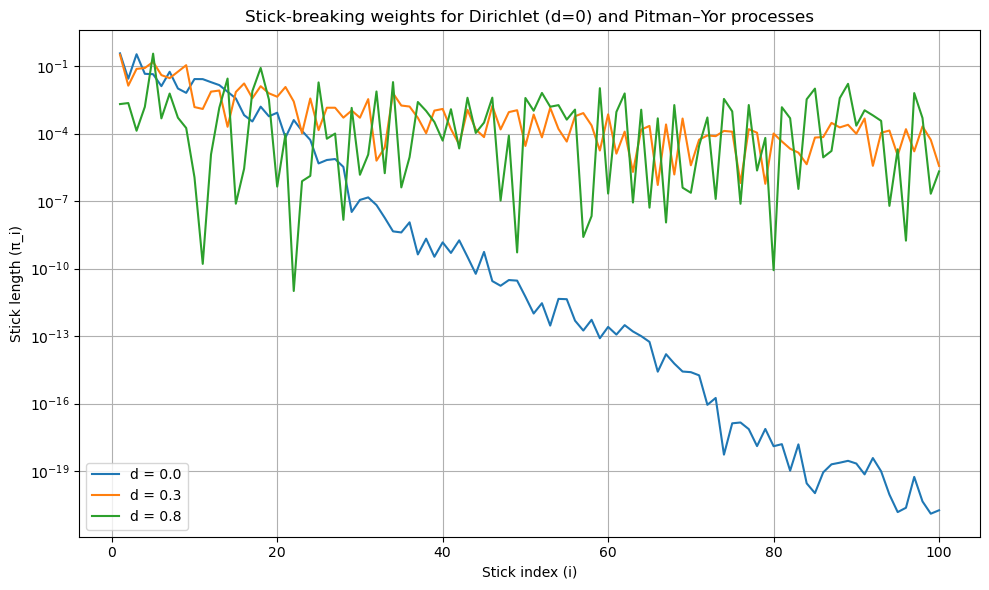

In [33]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import norm
from scipy.stats import beta
from scipy.stats import uniform
import collections

# Parameters
theta = 2
num_sticks = 100

# Define discount parameters
discounts = [0.0, 0.3, 0.8]  # d = 0.0 is DP; others are PY
stick_breaks = {}

# Generate stick lengths for different discount values
  # for reproducibility
for d in discounts:
    remaining = 1.0
    pis = []
    for i in range(1, num_sticks + 1):
        a = 1 - d
        b = theta + i * d
        v = beta.rvs(a, b)
        pi = v * remaining
        pis.append(pi)
        remaining *= (1 - v)
    stick_breaks[d] = pis

# Plot
plt.figure(figsize=(10, 6))
for d, pis in stick_breaks.items():
    plt.plot(range(1, num_sticks + 1), pis, label=f"d = {d}")

plt.title("Stick-breaking weights for Dirichlet (d=0) and Pitman–Yor processes")
plt.xlabel("Stick index (i)")
plt.ylabel("Stick length (π_i)")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


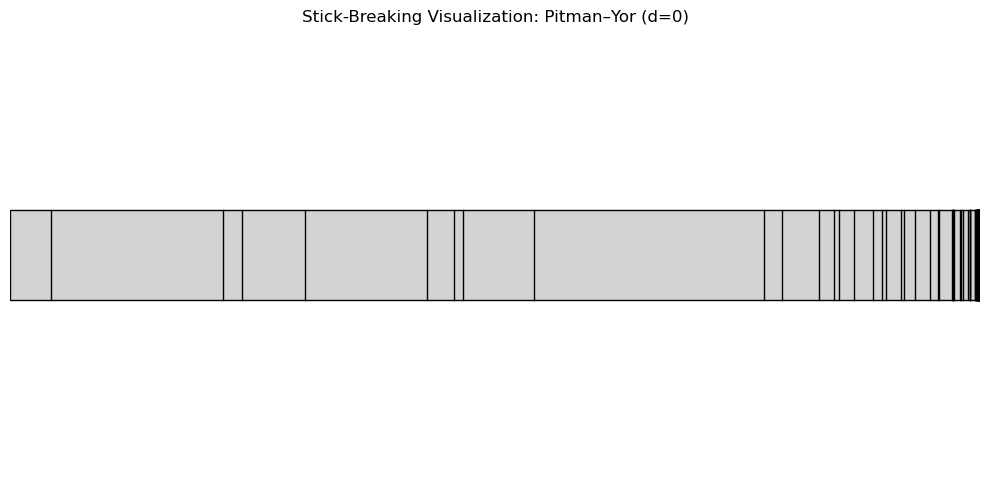

In [53]:


breaks_prob = []
epsilon = 0.0001
theta = 10
d = 0
prob = 0
i = 0
remaining = 1
while prob <= 1 - epsilon:
    a = 1-d
    b = theta + i * d
    v = beta.rvs(a,b)
    pi = v*remaining
    i = i+1
    remaining = remaining - pi
    prob = prob + pi
    breaks_prob.append((pi,prob))
breaks_prob.append((1-prob,1.0))

breaks = [x[0] for x in breaks_prob ]
cumprobs = np.array([x[1] for x in breaks_prob ])

# Plot the stick-breaking visualization
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

# Draw the base rectangle
base = patches.Rectangle((0, 0.4), 1, 0.2, edgecolor='black', facecolor='lightgray')
ax.add_patch(base)

# Draw vertical cuts and annotate weights
start = 0
for pi in breaks:
    end = start + pi
    ax.plot([end, end], [0.4, 0.6], color='black', linewidth=1)
    start = end

plt.title(f"Stick-Breaking Visualization: Pitman–Yor (d={d})", fontsize=12)
plt.tight_layout()
plt.show()


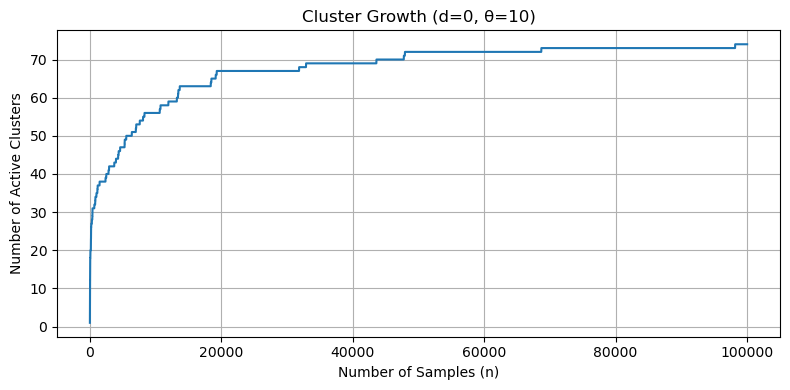

In [54]:
n_samples = 100000
active_clusters = set()
growth = []

for n in range(1, n_samples + 1):
    h = uniform.rvs(0, 1)
    for k, cp in enumerate(cumprobs):
        if h <= cp:
            active_clusters.add(k)
            break
    growth.append(len(active_clusters))

# Plotting the growth of the number of active clusters
plt.figure(figsize=(8, 4))
plt.plot(range(1, n_samples + 1), growth)
plt.xlabel("Number of Samples (n)")
plt.ylabel("Number of Active Clusters")
plt.title(f"Cluster Growth (d={d}, θ={theta})")
plt.grid(True)
plt.tight_layout()
plt.show()



In [61]:
def stick_breaking_process(theta, d, mean, epsilon):
    cumprob = 0
    df = []
    component = 1
    i = 0

    while cumprob < 1 - epsilon:
        a = 1 - d
        b = theta + i * d
        v = float(np.random.beta(a, b,1))
        prob = (1 - cumprob) * v
        cumprob += prob
        
        theta_k = np.random.normal(mean, 1)
        df.append((component, theta_k, prob, cumprob))

        component += 1
        i += 1

    theta_k = np.random.normal(mean, 1)
    df.append((component, theta_k, 1 - cumprob, 1))

    return pd.DataFrame(df, columns=['component', 'theta', 'prob', 'cumprob'])


/var/folders/sk/5wry1hlx7v7__gc97120n0tc0000gn/T/ipykernel_34113/110931218.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v = float(np.random.beta(a, b,1))


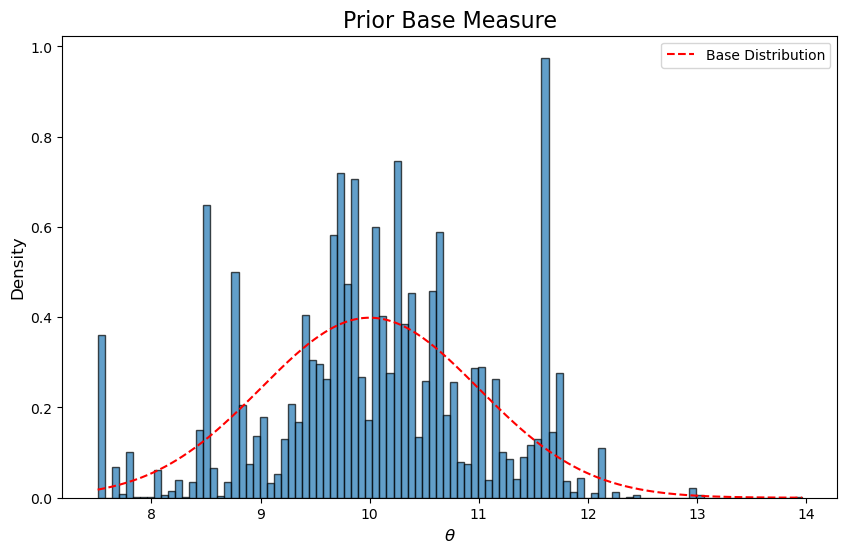

In [62]:

theta = 4
d = 0
epsilon = 0.001
mean = 10


DPsample = stick_breaking_process(theta,d, mean, epsilon)

n_runs = 20

all_thetas_prior = []
all_probs_prior = []

for _ in range(n_runs):
    df = stick_breaking_process(theta,d, 10, epsilon)
    all_thetas_prior.extend(df['theta'])
    all_probs_prior.extend(df['prob'])

n_bins = 100
prior_bins = np.linspace(min(all_thetas_prior), max(all_thetas_prior), n_bins + 1)

plt.figure(figsize=(10, 6))
plt.hist(all_thetas_prior, bins=prior_bins, weights=np.array(all_probs_prior) / n_runs, edgecolor='k', alpha=0.7, density=True)

plt.xlabel(r'$\theta$', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Prior Base Measure', fontsize=16)
x = np.linspace(min(all_thetas_prior), max(all_thetas_prior), 500)
plt.plot(x, norm.pdf(x, loc=10, scale=1), label='Base Distribution', color='red', linestyle='--')
plt.legend()








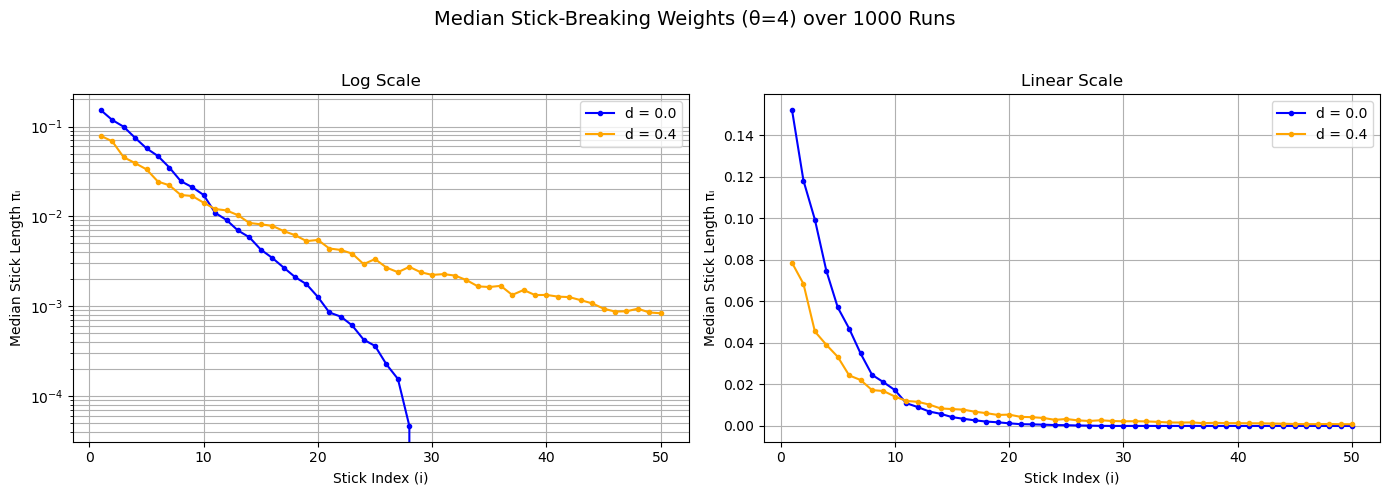

In [63]:
n_runs = 1000
max_length = 50
d_values = [0.0, 0.4]  
colors = ['blue', 'orange']

# Store median weights for each d
median_by_d = {}

for d in d_values:
    all_weights = []

    for _ in range(n_runs):
        prob = 0
        remaining = 1
        i = 0
        weights = []

        while prob < 1 - epsilon and i < max_length:
            a = 1 - d
            b = theta + i * d
            v = beta.rvs(a, b)
            pi = v * remaining
            weights.append(pi)
            remaining -= pi
            prob += pi
            i += 1

        # Pad with zeros
        while len(weights) < max_length:
            weights.append(0.0)

        all_weights.append(weights)

    all_weights = np.array(all_weights)
    median_weights = np.median(all_weights, axis=0)
    median_by_d[d] = median_weights

# Plotting

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

for d, color in zip(d_values, colors):
    x_vals = range(1, max_length + 1)
    y_vals = median_by_d[d]
  
    axes[0].semilogy(x_vals, y_vals, marker='o', markersize=3, linestyle='-', label=f'd = {d}', color=color)

    axes[1].plot(x_vals, y_vals, marker='o', markersize=3, linestyle='-', label=f'd = {d}', color=color)

# Customize both plots
axes[0].set_title("Log Scale")
axes[1].set_title("Linear Scale")

for ax in axes:
    ax.set_xlabel("Stick Index (i)")
    ax.set_ylabel("Median Stick Length πᵢ")
    ax.grid(True, which='both')
    ax.legend()

fig.suptitle(f"Median Stick-Breaking Weights (θ={theta}) over {n_runs} Runs", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

/var/folders/sk/5wry1hlx7v7__gc97120n0tc0000gn/T/ipykernel_34113/110931218.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v = float(np.random.beta(a, b,1))


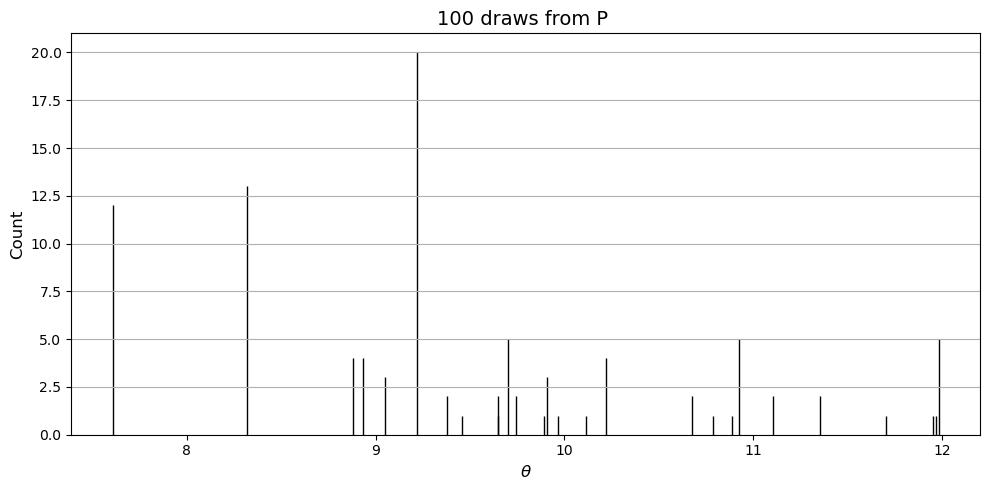

In [ ]:

true_distr = stick_breaking_process(10,0,10,0.0001)

def sample_from_stick_measure(true_distr):
    v = np.random.uniform(0, 1)
    for i, cp in enumerate(true_distr['cumprob']):
        if v <= cp:
            return true_distr['theta'].iloc[i]

sample=[]

for _ in range(100):
    x = sample_from_stick_measure(true_distr)
    sample.append(x)



counter = collections.Counter(sample)

# Sort by θ for clean plotting
theta_vals = sorted(counter.keys())
frequencies = [counter[θ] for θ in theta_vals]

# Bar plot = point masses
plt.figure(figsize=(10, 5))
plt.bar(theta_vals, frequencies, width=0.00001, color='blue', edgecolor='k')
plt.xlabel(r'$\theta$', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('100 draws from P ', fontsize=14)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

